# Домашнее задание. Transformers.

Привет! Это очередное домашнее задание, но теперь ты познакомишься с моделя трансформеров и с библиотекой `HuggingFace🤗`. В этом задании будет предложено решить с помощью модели `GPT2` простую задачу (анализ сентимента) и сделать небольшое исследование карт внимания. Приступим!

Student: Oleg Navolotsky / Олег Наволоцкий  
Stepik: https://stepik.org/users/2403189  
Telegram: [@oleg_navolotsky](https://t.me/oleg_navolotsky)  

**Note**: reproducibility depends on [different things](https://pytorch.org/docs/stable/notes/randomness.html):
>Completely reproducible results are not guaranteed across PyTorch releases, individual commits, or different platforms. Furthermore, results may not be reproducible between CPU and GPU executions, even when using identical seeds.

In [1]:
COLAB = None
DONT_USE_GPU = None

if COLAB is None:
    try:
        import google.colab
    except ModuleNotFoundError:
        COLAB = False
    else:
        COLAB = True

if DONT_USE_GPU is None:
    DONT_USE_GPU = not COLAB

COLAB, DONT_USE_GPU

(False, True)

In [2]:
if COLAB:
    !pip install -q transformers datasets tokenizers

In [3]:
import warnings

warnings.filterwarnings("ignore", module="ipykernel", category=DeprecationWarning)
warnings.filterwarnings("ignore", module="tensorflow", category=DeprecationWarning)

In [4]:
if COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    import os
    os.chdir("/content/drive/MyDrive/MIPT_DLS_II/14.1 Домашнее задание. Transformers+")
    print(os.getcwd())

In [5]:
import os

if COLAB:
    CACHE_BASE_DIR = os.path.join(os.getcwd(), ".cache")
else:
    CACHE_BASE_DIR = r"C:\.data_science_cache"

CACHE_BASE_DIR

'C:\\.data_science_cache'

In [6]:
import torch

def try_to_clear_gpu_memory(gpu_related_variables_names=("model", "optimizer", "criterion", "scheduler")):
    for name in gpu_related_variables_names:
        try:
            del globals()[name]
        except KeyError:
            pass
    torch.cuda.empty_cache()

In [7]:
import os
import random

import numpy as np
import torch


SEED = 42


def enable_reproducibility(
        seed=SEED, raise_if_no_deterministic=True,
        cudnn_deterministic=True, disable_cudnn_benchmarking=True):
    # https://pytorch.org/docs/stable/notes/randomness.html#avoiding-nondeterministic-algorithms
    torch.use_deterministic_algorithms(raise_if_no_deterministic)

    # https://docs.nvidia.com/cuda/cublas/index.html#cublasApi_reproducibility
    os.environ['CUBLAS_WORKSPACE_CONFIG'] = ":4096:8"
    
    torch.backends.cudnn.benchmark = not disable_cudnn_benchmarking
    torch.backends.cudnn.deterministic = cudnn_deterministic

    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

In [8]:
enable_reproducibility()

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker

import torch
import torch.nn as nn

from transformers import GPT2ForSequenceClassification, GPT2TokenizerFast, GPT2Config
from datasets import load_dataset

C:\Users\user0\anaconda3\envs\custom\lib\site-packages\ipykernel\pylab\config.py:70: DeprecationWarning: InlineBackend._figure_formats_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _figure_formats_changed(self, name, old, new):
C:\Users\user0\anaconda3\envs\custom\lib\site-packages\packaging\version.py:127: DeprecationWarning: Creating a LegacyVersion has been deprecated and will be removed in the next major release
  warnings.warn(


In [10]:
if DONT_USE_GPU:
    device = torch.device("cpu")
else:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

Датасет, который мы будем использовать сегодня – тексты из английского твиттера. Они уже почищенны от никнеймов, знаков препинания и прочего. 

In [11]:
emotion_dataset = load_dataset("emotion", cache_dir=os.path.join(CACHE_BASE_DIR, r"huggingface\datasets"), keep_in_memory=True)

Using custom data configuration default
Reusing dataset emotion (C:\.data_science_cache\huggingface\datasets\emotion\default\0.0.0\aa34462255cd487d04be8387a2d572588f6ceee23f784f37365aa714afeb8fe6)


Посмотри, из чего состоит `emotion_dataset`:

In [12]:
emotion_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [13]:
emotion_dataset["train"]

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [14]:
emotion_dataset["train"]["text"][0]

'i didnt feel humiliated'

In [15]:
emotion_dataset["train"]["label"][0]

0

In [16]:
len(emotion_dataset["train"])

16000

Для перевода текста в токены мы будем использовать предобученный BPE-токенайзер.

In [17]:
tokenizer = GPT2TokenizerFast.from_pretrained(
    "distilgpt2",
    cache_dir=os.path.join(CACHE_BASE_DIR, r"huggingface\pretrained_models\distilgpt2\tokenizers"))
tokenizer.pad_token = tokenizer.eos_token  # У gpt2 нет pad токенов. Вместо них воспользуемся токенами конца текста.

Подготовь класс, который принимает датасет, токенайзер и имя используемой части (`train`, `validation`, `test`). Используй его для получения данных для обучения.

P.S. Посмотри, как работает токенайзер ([docs](https://huggingface.co/transformers/main_classes/tokenizer.html)) и подумай, как его надо добавить в датасет.

Немного примеров, как работает токенайзер. Это поможет с написанием датасета.

In [18]:
tokenizer.tokenize(emotion_dataset["train"]["text"][0])

['i', 'Ġdidnt', 'Ġfeel', 'Ġhumiliated']

In [19]:
tokenizer.encode(emotion_dataset["train"]["text"][0])

[72, 42547, 1254, 42659]

In [20]:
tokenizer.encode_plus(emotion_dataset["train"]["text"][0])

{'input_ids': [72, 42547, 1254, 42659], 'attention_mask': [1, 1, 1, 1]}

In [21]:
tokenizer.encode_plus(emotion_dataset["train"]["text"][0], return_tensors="pt")

{'input_ids': tensor([[   72, 42547,  1254, 42659]]), 'attention_mask': tensor([[1, 1, 1, 1]])}

In [22]:
tokenizer.encode_plus(
    emotion_dataset["train"]["text"][0], 
    max_length=128, # максимальная длина текста
    padding="max_length", # надо ли добавлять паддинг в конце?
    return_tensors="pt", # возвращает pytorch тензоры
)

{'input_ids': tensor([[   72, 42547,  1254, 42659, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 5

In [23]:
# Если надо, попрактикуйся работать с токенайзером здесь

In [24]:
class TweetDataset(torch.utils.data.Dataset):
    def __init__(self, part, dataset=emotion_dataset, tokenizer=tokenizer, max_length=128):
        self.part = part
        self.dataset = dataset
        self.tokenizer = tokenizer
        self.max_length = max_length
        
        self.labels = np.unique(dataset[part]["label"])
        self.label2num = {l: num for num, l in enumerate(self.labels)}
        
    def __getitem__(self, idx):
        """
        Return dict with tokens, attention_mask and label
        """
        text = self.dataset[self.part]['text'][idx]
        label = self.dataset[self.part]['label'][idx]
        
        tokenizer_output = self.tokenizer.encode_plus(
            text, padding="max_length", max_length=self.max_length, 
            return_tensors="pt",
        )
        target = self.label2num[label]
        return {
            "input_ids": tokenizer_output['input_ids'].squeeze(0), 
            "mask": tokenizer_output['attention_mask'].squeeze(0),
            "target": target
        }
        
    def __len__(self):
        """
        Return length of dataset
        """
        return len(self.dataset[self.part])

Создай `train`, `validation` и `test` части датасета. Загрузи их в `DataLoaders`.

In [25]:
train_dataset = TweetDataset("train", emotion_dataset, tokenizer)
valid_dataset = TweetDataset("validation", emotion_dataset, tokenizer)
test_dataset = TweetDataset("test", emotion_dataset, tokenizer)

In [26]:
enable_reproducibility()

batch_size = 64  # Задай batch_size

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, drop_last=True
)
valid_loader = torch.utils.data.DataLoader(
    valid_dataset, batch_size=batch_size
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size
)

## Начнем с нуля.

Попробуем обучить модель трансформер с нуля решать данную задачу.

In [27]:
NUM_LABELS = len((set(emotion_dataset['train']['label'])))
NUM_LABELS

6

In [28]:
# try_to_clear_gpu_memory(["model_0", "optimizer", "criterion", "scheduler"])

In [29]:
enable_reproducibility()

config = GPT2Config.from_pretrained(
    "distilgpt2",  # distilgpt2 – уменьшенная версия модели gpt2
    output_attentions=True,
    pad_token_id=tokenizer.eos_token_id,
    num_labels=NUM_LABELS,
    cache_dir=os.path.join(CACHE_BASE_DIR, r"huggingface\pretrained_models\distilgpt2\config")
)
model_0 = GPT2ForSequenceClassification(config=config).to(device)  # GPT2 для классификации текста

Подготовь оптимайзер и критерий:

In [30]:
lr = 1e-5  # Предполагаемый learning rate. Он может быть больше или меньше :)

optimizer = torch.optim.Adam(model_0.parameters(), lr=lr)
criterion = torch.nn.CrossEntropyLoss()
scheduler = None  # Можно добавить шедулер для обучения моделей. Это на твое усмотрение

Посмотри, что возвращает модель ([docs](https://huggingface.co/transformers/model_doc/gpt2.html#gpt2forsequenceclassification)), если в неё подать данные:

In [29]:
tokens = train_dataset[0]['input_ids'].unsqueeze(0).to(device)  # Получи токены из датасета
mask = train_dataset[0]['mask'].unsqueeze(0).to(device)

model_0.eval()
with torch.no_grad():
    outputs = model_0(input_ids=tokens, attention_mask=mask)  # Посмотри на аутпут

In [30]:
type(outputs), isinstance(outputs, dict)

(transformers.modeling_outputs.SequenceClassifierOutputWithPast, True)

In [31]:
{key: type(value) for key, value in outputs.items()}

{'attentions': tuple, 'logits': torch.Tensor, 'past_key_values': tuple}

In [32]:
assert outputs.logits.shape[-1] == NUM_LABELS, outputs.logits.shape

Обучи модель с помощью `train_dataset`, проверяй во время обучения качество с помощью `valid_dataset` и получи финальное качество с помощью `test_dataset`.

In [29]:
from tqdm.notebook import tqdm


def train(model, dataloader, criterion, optimizer):
    model.train()
    train_loss_sum = 0
    for batch in tqdm(dataloader, desc="training", leave=False):
        features = batch['input_ids'].to(device)
        attention_mask = batch['mask'].to(device)
        targets = batch['target'].to(device)
        
        optimizer.zero_grad()
        outputs = model(input_ids=features, attention_mask=attention_mask)
        loss = criterion(outputs.logits, targets)
        loss.backward()
        optimizer.step()

        train_loss_sum += loss.item()
    return train_loss_sum / len(dataloader)

@torch.no_grad()
def validate(model, dataloader, criterion, test=False, print_results=False):
    model.eval()
    loss_sum = 0
    true_preds = 0
    total_examples = 0
    desc = "testing" if test else "validation"
    for batch in tqdm(dataloader, desc="testing" if test else "validation", leave=False):
        features = batch['input_ids'].to(device)
        attention_mask = batch['mask'].to(device)
        targets = batch['target'].to(device)

        outputs = model(input_ids=features, attention_mask=attention_mask)
        loss = criterion(outputs.logits, targets)
        
        loss_sum += loss.item()
        true_preds += (outputs.logits.argmax(-1) == targets).sum().item()
        total_examples += features.shape[0]
    res = dict(
        loss=loss_sum / len(dataloader), accuracy=true_preds / total_examples,
        mode = "Test" if test else "Valid")
    if print_results:
        print("{mode} Loss: {loss} | {mode} Accuracy: {accuracy}".format(**res))
    return res

def train_validate_model(
        model, num_epochs, train_loader, critertion, optimizer,
        valid_loader=None, lr_scheduler=None, start_epoch=1,
        save_after_each_epoch=False, name_for_save="model"):
    for e in tqdm(range(start_epoch, num_epochs + 1), desc="epoch"):
        train_loss = train(model, train_loader, criterion, optimizer)
        report_msg = f"Epoch: {e} | Train Loss: {train_loss}"
        if valid_loader is not None:
            valid_res = validate(model, valid_loader, criterion)
            report_msg += " | Valid Loss: {loss} | Valid Accuracy: {accuracy}".format(**valid_res)
        if save_after_each_epoch:
            save_model(model, name_for_save, e, num_epochs, report=True)
        if lr_scheduler is not None:
            lr_scheduler.step()
        print(report_msg)

def save_model(model, name, epoch=None, total_epochs=None, report=False):
    dirname = f"{name}"
    if epoch is not None:
        dirname += f"_ep_{epoch}"
    path = os.path.join(CACHE_BASE_DIR, dirname)
    model.save_pretrained(path)
    if report:
        report_msg = "model saved "
        if epoch is not None:
            report_msg += f"(epoch {epoch}"
            if total_epochs is not None:
                report_msg += f" / {total_epochs}"
            report_msg += ") "
        report_msg += f"to {path}"
        print(report_msg)
    return path

def load_model(name, epoch=None, cls=GPT2ForSequenceClassification, device=None, report=False):
    dirname = f"{name}"
    if epoch is not None:
        dirname += f"_ep_{epoch}"
    path = os.path.join(CACHE_BASE_DIR, dirname)
    model = cls.from_pretrained(path)
    if device is not None:
        model = model.to(device)
    if report:
        print(f"model loaded from {path}")
    return model

In [59]:
%%time

enable_reproducibility(raise_if_no_deterministic=False)

num_epochs = 10

train_validate_model(
    model_0, num_epochs, train_loader, criterion, optimizer,
    valid_loader=valid_loader, lr_scheduler=scheduler,
    save_after_each_epoch=True, name_for_save="model_0")

enable_reproducibility()

model saved (epoch 1 / 10) to /content/drive/MyDrive/MIPT_DLS_II/14.1 Домашнее задание. Transformers+/.cache/model_0_ep_1
Epoch: 1 | Train Loss: 1.5635715727806092 | Valid Loss: 1.4333654902875423 | Valid Accuracy: 0.443


model saved (epoch 2 / 10) to /content/drive/MyDrive/MIPT_DLS_II/14.1 Домашнее задание. Transformers+/.cache/model_0_ep_2
Epoch: 2 | Train Loss: 1.2881177740097045 | Valid Loss: 1.097470697015524 | Valid Accuracy: 0.591


model saved (epoch 3 / 10) to /content/drive/MyDrive/MIPT_DLS_II/14.1 Домашнее задание. Transformers+/.cache/model_0_ep_3
Epoch: 3 | Train Loss: 0.9267378653287888 | Valid Loss: 0.9058079589158297 | Valid Accuracy: 0.672


model saved (epoch 4 / 10) to /content/drive/MyDrive/MIPT_DLS_II/14.1 Домашнее задание. Transformers+/.cache/model_0_ep_4
Epoch: 4 | Train Loss: 0.6695159022808075 | Valid Loss: 0.6938773235306144 | Valid Accuracy: 0.7505


model saved (epoch 5 / 10) to /content/drive/MyDrive/MIPT_DLS_II/14.1 Домашнее задание. Transformers+/.cache/model_0_ep_5
Epoch: 5 | Train Loss: 0.4972156049013138 | Valid Loss: 0.6447046073153615 | Valid Accuracy: 0.7815


model saved (epoch 6 / 10) to /content/drive/MyDrive/MIPT_DLS_II/14.1 Домашнее задание. Transformers+/.cache/model_0_ep_6
Epoch: 6 | Train Loss: 0.37626848548650743 | Valid Loss: 0.58577786013484 | Valid Accuracy: 0.8115


model saved (epoch 7 / 10) to /content/drive/MyDrive/MIPT_DLS_II/14.1 Домашнее задание. Transformers+/.cache/model_0_ep_7
Epoch: 7 | Train Loss: 0.3005338413119316 | Valid Loss: 0.5596758043393493 | Valid Accuracy: 0.827


model saved (epoch 8 / 10) to /content/drive/MyDrive/MIPT_DLS_II/14.1 Домашнее задание. Transformers+/.cache/model_0_ep_8
Epoch: 8 | Train Loss: 0.23035890711843968 | Valid Loss: 0.5146089601330459 | Valid Accuracy: 0.8445


model saved (epoch 9 / 10) to /content/drive/MyDrive/MIPT_DLS_II/14.1 Домашнее задание. Transformers+/.cache/model_0_ep_9
Epoch: 9 | Train Loss: 0.1926125134974718 | Valid Loss: 0.513161753769964 | Valid Accuracy: 0.8475


model saved (epoch 10 / 10) to /content/drive/MyDrive/MIPT_DLS_II/14.1 Домашнее задание. Transformers+/.cache/model_0_ep_10
Epoch: 10 | Train Loss: 0.1585969918742776 | Valid Loss: 0.5409840089268982 | Valid Accuracy: 0.846

CPU times: user 1h 25min 58s, sys: 26min 50s, total: 1h 52min 49s
Wall time: 1h 52min 50s


In [60]:
%%time
test_res = validate(model_0, test_loader, criterion, test=True, print_results=True)

Test Loss: 0.5232794820331037 | Test Accuracy: 0.832
CPU times: user 14 s, sys: 6.42 s, total: 20.5 s
Wall time: 20.4 s


После того, как получил лучшую модель для решения этой задачи, посмотри на карты внимания. Нашел ли что-нибудь интересное в них?

In [30]:
def get_attention_matrixes(model, tokenizer, text, device=device):
    inp = [x for x in tokenizer.encode(text) if x != tokenizer.sep_token_id]
    seq = [tokenizer.decode(x) for x in inp]
    inp = torch.tensor(inp, dtype=torch.long, device=device).unsqueeze(0)
    attn_tensors_tuple = model(inp).attentions
    attns = np.array([t[0].detach().cpu().numpy() for t in attn_tensors_tuple])
    return seq, attns

In [31]:
def show_attention(seq, attentions):
    # Set up figure with colorbar
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions)
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels(['']+seq, rotation=90, fontsize=16)
    ax.set_yticklabels(['']+seq, fontsize=16)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [32]:
def show_all_attentions(seq, attentions):
    if len(attentions.shape) != 4:
        raise ValueError(
            "`attentions` expected to be of shape [layers num, "
            f"heads num, seq len, seq len], not {attentions.shape}")
    
    layers_num, heads_num, *_ = attns.shape
    fig = plt.figure(figsize=(4 * layers_num, 4.5 * heads_num))
    axes = fig.subplots(heads_num, layers_num, squeeze=False)
    
    for l_num in range(layers_num):
        for h_num in range(heads_num):
            ax = axes[h_num][l_num]
            ax.set_title(f"layer #{l_num}, head #{h_num}")
            ax.set_axis_off()
            cax = ax.matshow(attentions[l_num][h_num])

    # Set up axes
    axes[0][0].set_axis_on()
    axes[0][0].set_xticklabels(['']+seq, rotation=90)
    axes[0][0].set_yticklabels(['']+seq,)
    # Show label at every tick
    axes[0][0].xaxis.set_major_locator(ticker.MultipleLocator(1))
    axes[0][0].yaxis.set_major_locator(ticker.MultipleLocator(1))

    # Set up figure with colorbar
    fig.colorbar(cax, ax=axes[0][1])
    
    plt.show()

In [33]:
num_epochs = 10  # last ep
model_0 = load_model("model_0", num_epochs, device=device, report=True)

model loaded from C:\.data_science_cache\model_0_ep_10


In [34]:
text_id = 42
text = emotion_dataset["test"]["text"][text_id]
text

'i feel reassured that i am dealing with my diet in the right way and that all is good'

In [35]:
tokens, attns = get_attention_matrixes(model_0, tokenizer, text, device=device)
print(*tokens)

i  feel  reassured  that  i  am  dealing  with  my  diet  in  the  right  way  and  that  all  is  good


In [36]:
print(*[f"{dim} = {size}" for dim, size in zip(["layers", "heads", "seq len", "seq len"], attns.shape)], sep=" | ")

layers = 6 | heads = 12 | seq len = 19 | seq len = 19


<ipython-input-32-81e460141e0f>:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0][0].set_xticklabels(['']+seq, rotation=90)
<ipython-input-32-81e460141e0f>:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0][0].set_yticklabels(['']+seq,)


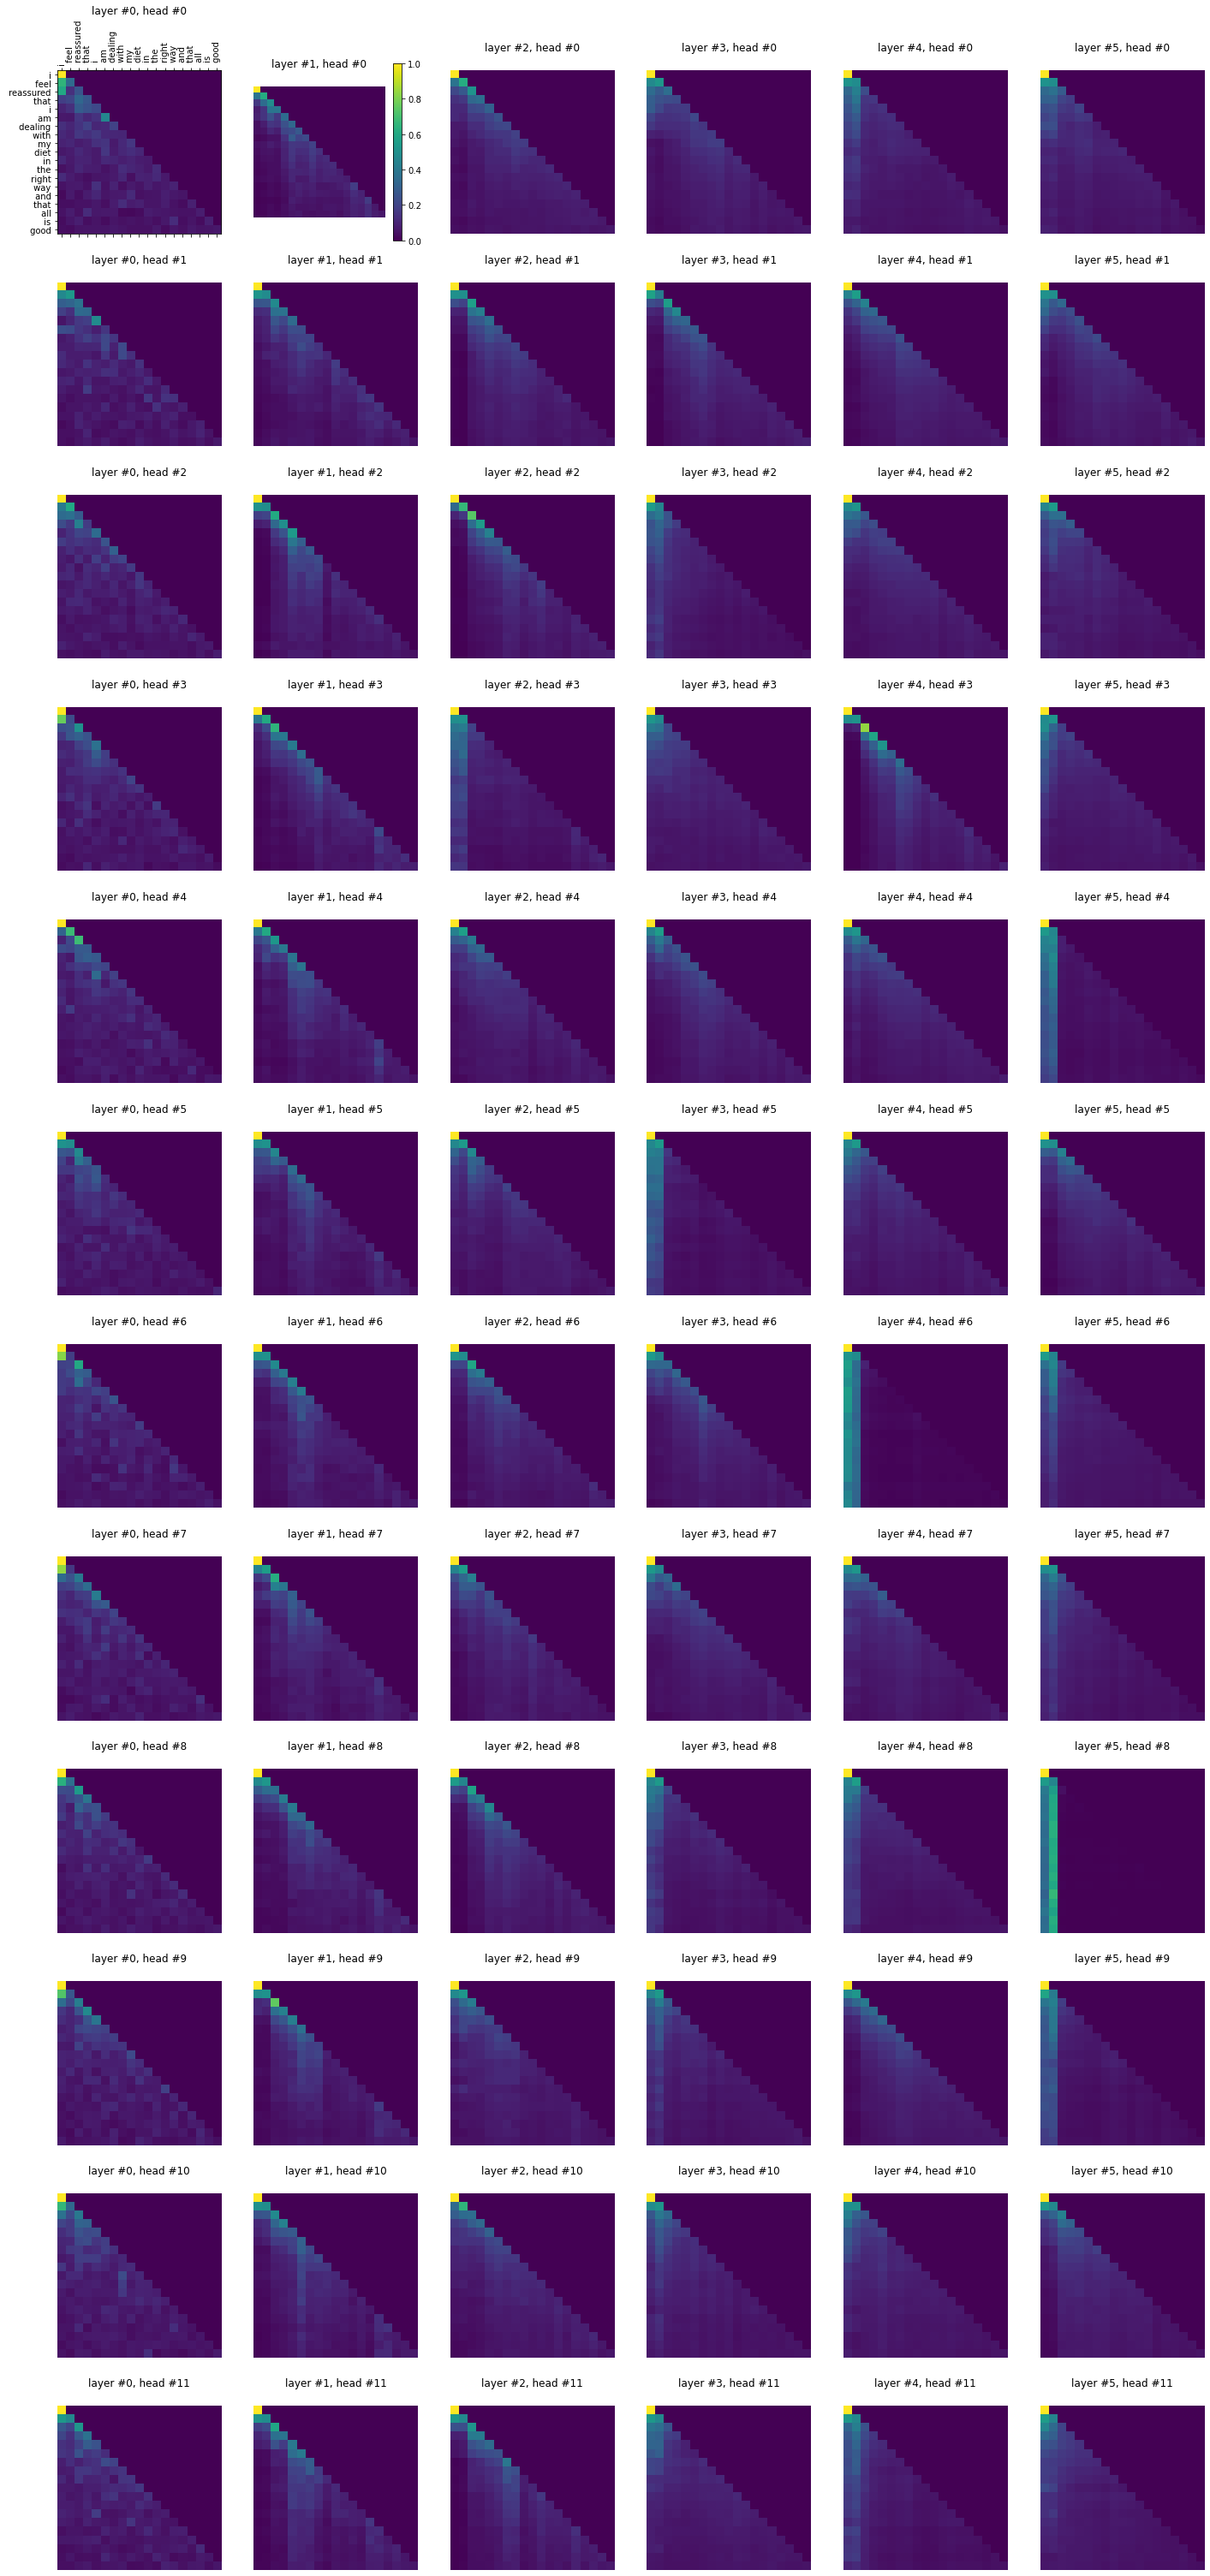

In [37]:
show_all_attentions(tokens, attns)

## Fine-tuning

Теперь другой подход: загрузим модель, которая обучалась решать задачу Language Modeling. Посмотрим, получим ли мы прирост в качестве.

In [ ]:
try_to_clear_gpu_memory(["model_0", "optimizer", "criterion", "scheduler"])

In [32]:
model_1 = GPT2ForSequenceClassification.from_pretrained(
    "distilgpt2", 
    output_attentions=True,
    pad_token_id=tokenizer.eos_token_id,
    num_labels=NUM_LABELS,
    cache_dir=os.path.join(CACHE_BASE_DIR, r"huggingface\pretrained_models\distilgpt2\GPT2ForSequenceClassification")
).to(device)

Some weights of the model checkpoint at distilgpt2 were not used when initializing GPT2ForSequenceClassification: ['lm_head.weight']
- This IS expected if you are initializing GPT2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at distilgpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [34]:
lr = 1e-5  # Предполагаемый learning rate. Он может быть больше или меньше :)

optimizer = torch.optim.Adam(model_1.parameters(), lr=lr)
criterion = torch.nn.CrossEntropyLoss()
scheduler = None  # Можно добавить шедулер для обучения моделей. Это на твое усмотрение

Вывод модели ничем не отличается от предыдущего случая, поэтому сразу приступаем к обучению:

In [35]:
%%time

enable_reproducibility(raise_if_no_deterministic=False)

num_epochs = 10

train_validate_model(
    model_1, num_epochs, train_loader, criterion, optimizer,
    valid_loader=valid_loader, lr_scheduler=scheduler,
    save_after_each_epoch=True, name_for_save="model_1")

enable_reproducibility()

model saved (epoch 1 / 10) to /content/drive/MyDrive/MIPT_DLS_II/14.1 Домашнее задание. Transformers+/.cache/model_1_ep_1
Epoch: 1 | Train Loss: 1.7850530381202698 | Valid Loss: 1.2511820457875729 | Valid Accuracy: 0.5635


model saved (epoch 2 / 10) to /content/drive/MyDrive/MIPT_DLS_II/14.1 Домашнее задание. Transformers+/.cache/model_1_ep_2
Epoch: 2 | Train Loss: 0.8883693593740464 | Valid Loss: 0.4396176668815315 | Valid Accuracy: 0.854


model saved (epoch 3 / 10) to /content/drive/MyDrive/MIPT_DLS_II/14.1 Домашнее задание. Transformers+/.cache/model_1_ep_3
Epoch: 3 | Train Loss: 0.43191149389743805 | Valid Loss: 0.2572321759071201 | Valid Accuracy: 0.908


model saved (epoch 4 / 10) to /content/drive/MyDrive/MIPT_DLS_II/14.1 Домашнее задание. Transformers+/.cache/model_1_ep_4
Epoch: 4 | Train Loss: 0.28487930428981784 | Valid Loss: 0.22945433272980154 | Valid Accuracy: 0.9145


model saved (epoch 5 / 10) to /content/drive/MyDrive/MIPT_DLS_II/14.1 Домашнее задание. Transformers+/.cache/model_1_ep_5
Epoch: 5 | Train Loss: 0.22321637140214443 | Valid Loss: 0.19028441712725908 | Valid Accuracy: 0.9195


model saved (epoch 6 / 10) to /content/drive/MyDrive/MIPT_DLS_II/14.1 Домашнее задание. Transformers+/.cache/model_1_ep_6
Epoch: 6 | Train Loss: 0.18755786164104937 | Valid Loss: 0.1688723990228027 | Valid Accuracy: 0.9295


model saved (epoch 7 / 10) to /content/drive/MyDrive/MIPT_DLS_II/14.1 Домашнее задание. Transformers+/.cache/model_1_ep_7
Epoch: 7 | Train Loss: 0.16548036323487758 | Valid Loss: 0.1608343028347008 | Valid Accuracy: 0.935


model saved (epoch 8 / 10) to /content/drive/MyDrive/MIPT_DLS_II/14.1 Домашнее задание. Transformers+/.cache/model_1_ep_8
Epoch: 8 | Train Loss: 0.1498073752373457 | Valid Loss: 0.1488130969228223 | Valid Accuracy: 0.932


model saved (epoch 9 / 10) to /content/drive/MyDrive/MIPT_DLS_II/14.1 Домашнее задание. Transformers+/.cache/model_1_ep_9
Epoch: 9 | Train Loss: 0.14089297166466713 | Valid Loss: 0.1532885002088733 | Valid Accuracy: 0.932


model saved (epoch 10 / 10) to /content/drive/MyDrive/MIPT_DLS_II/14.1 Домашнее задание. Transformers+/.cache/model_1_ep_10
Epoch: 10 | Train Loss: 0.12903531613945962 | Valid Loss: 0.15064787410665303 | Valid Accuracy: 0.934

CPU times: user 1h 3min 12s, sys: 15min 59s, total: 1h 19min 11s
Wall time: 1h 19min 20s


In [36]:
%%time
test_res = validate(model_1, test_loader, criterion, test=True, print_results=True)

Test Loss: 0.15572225884534419 | Test Accuracy: 0.927
CPU times: user 9.59 s, sys: 4.04 s, total: 13.6 s
Wall time: 13.6 s


Есть ли прирост качества или скорости обучения?

Посмотри на карты внимания. Есть ли отличие от предыдущего случая?

In [37]:
# text = ... # Выбери текст из датасета
# tokens = tokenizer.tokenize(text)


In [38]:
num_epochs = 10  # last ep
model_1 = load_model("model_1", num_epochs, device=device, report=True)

model loaded from C:\.data_science_cache\model_1_ep_10


In [39]:
tokens, attns = get_attention_matrixes(model_1, tokenizer, text, device=device)
print(*tokens)

i  feel  reassured  that  i  am  dealing  with  my  diet  in  the  right  way  and  that  all  is  good


<ipython-input-32-81e460141e0f>:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0][0].set_xticklabels(['']+seq, rotation=90)
<ipython-input-32-81e460141e0f>:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0][0].set_yticklabels(['']+seq,)


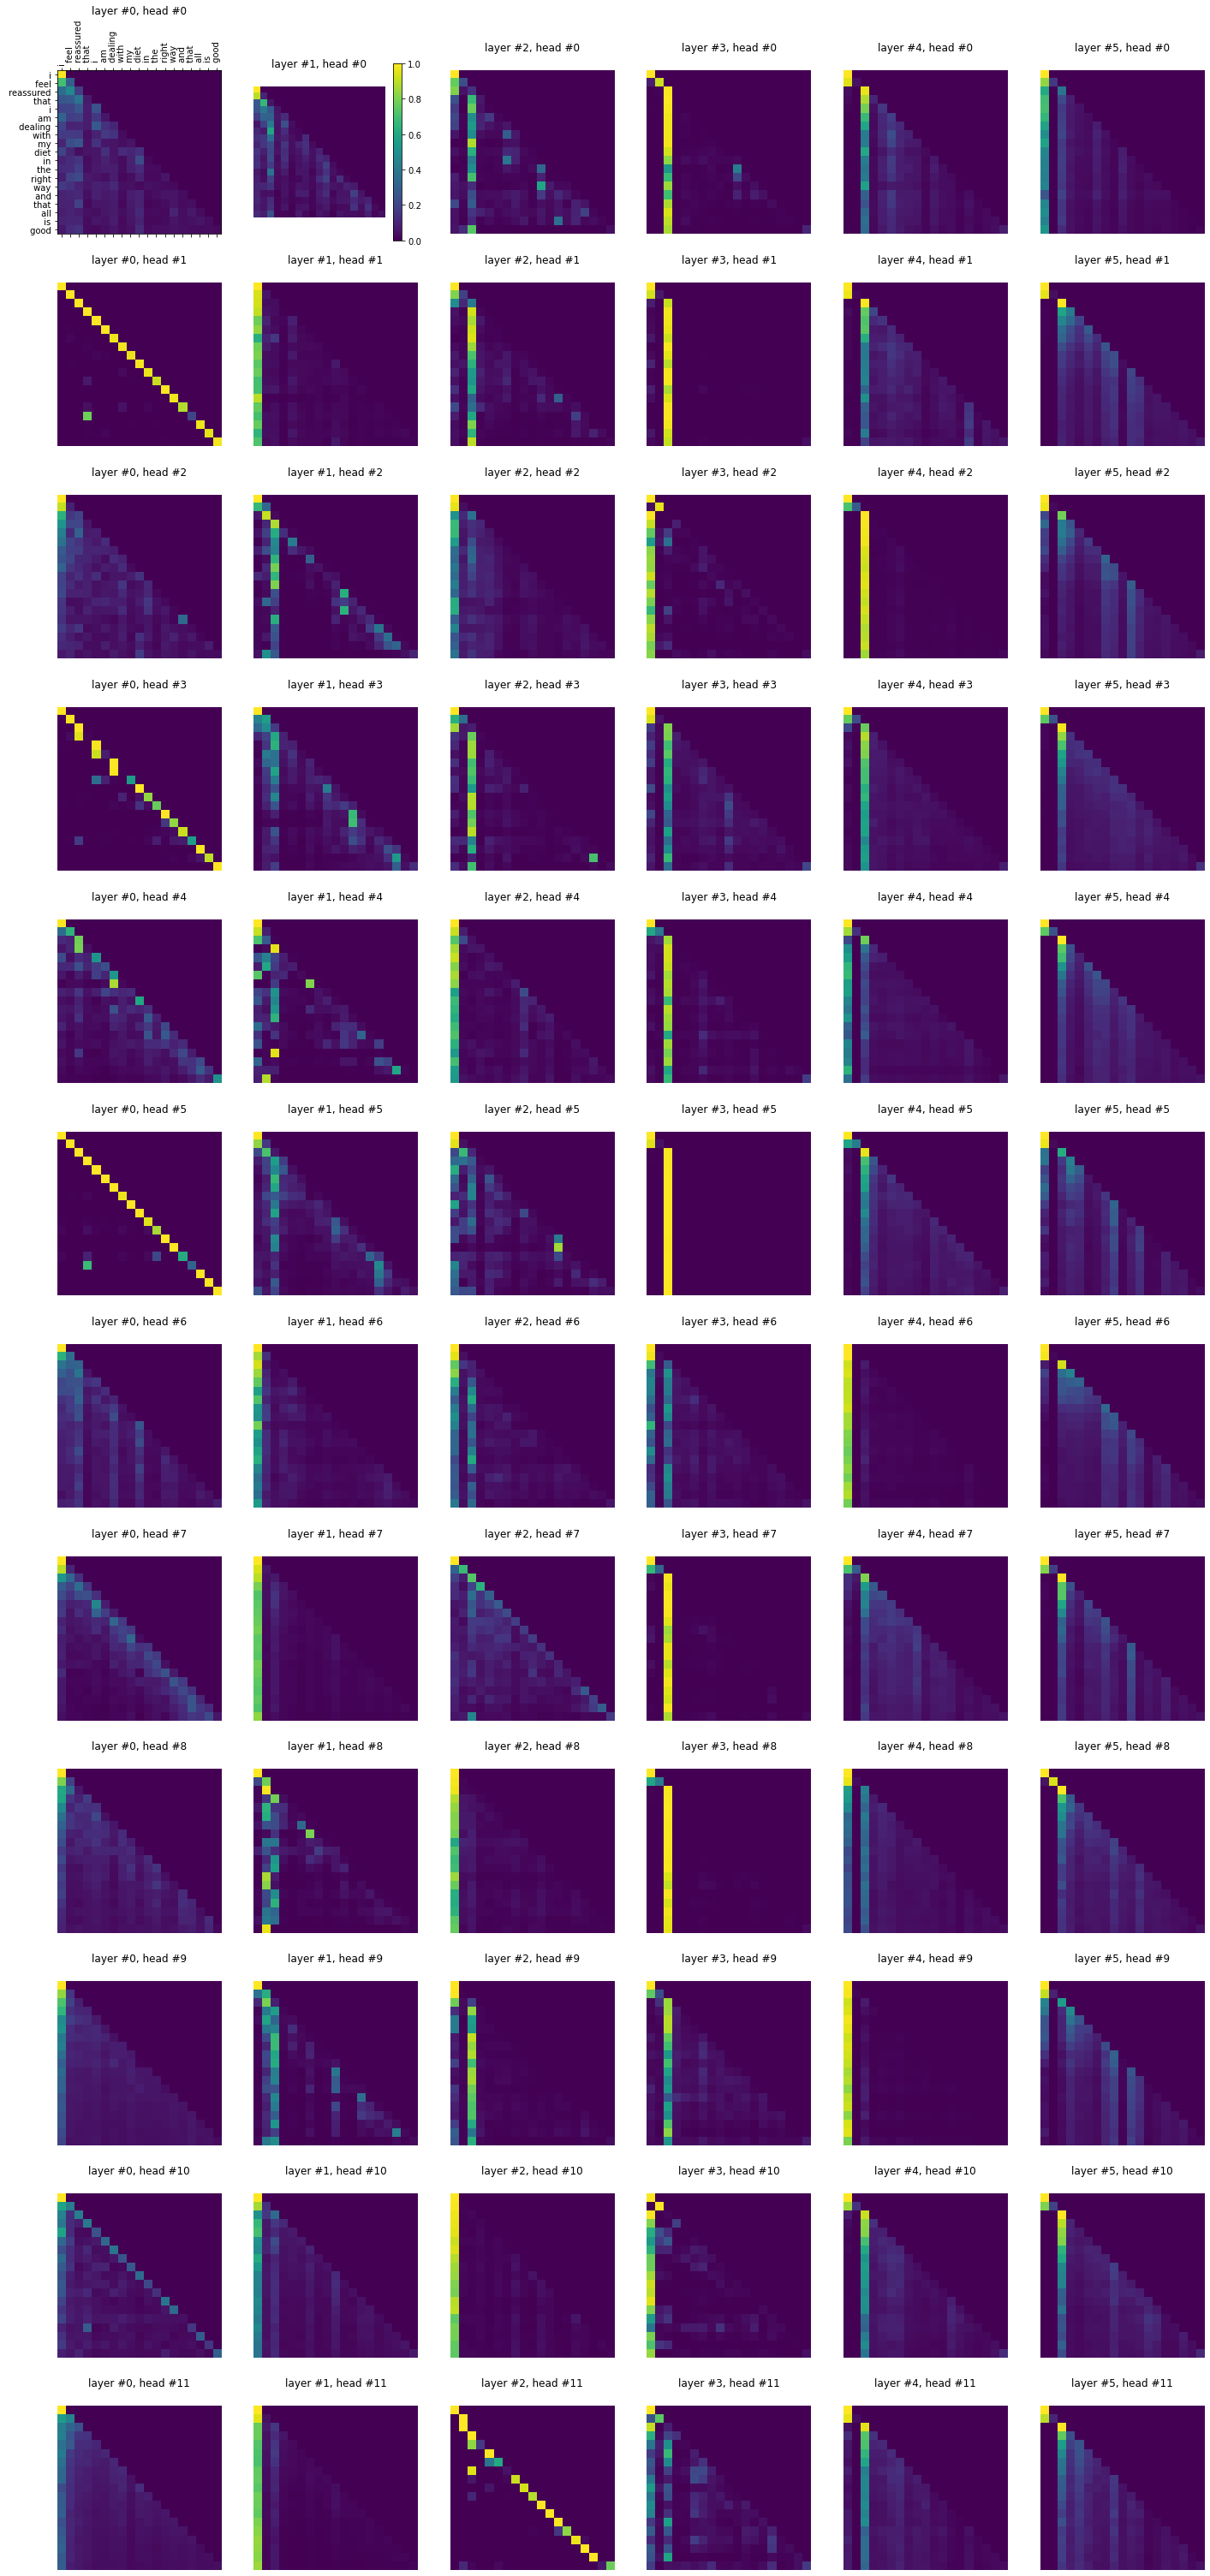

In [40]:
show_all_attentions(tokens, attns)

## Отчет

Покажи здесь, что ты выполнил по этой работе. Ответь на несколько вопросов:
- Q: Какой подход оказался лучше?
- A: Fine-tuning (а разве могло бы иначе?) показал превосходные результаты: высокие итоговый performance и скорость обучения. Уже на 2-й эпохе дообучаемая модель превзошла итоговые результаты обучаемой с нуля. Это также показывает высокое качество эмбеддингов, получаемых из решения задачи Language Modeling.

- Q: На какие слова модель большего всего обращала внимание?
- A: 
    - __Обученная с нуля__. Наблюдается общий паттерн: треугольники ярче в верхней части, что в целом логично, так как модель могла смотреть только назад, а если слов меньше, то и значения весов, суммируемые в единцу, больше, и кроме того, модель училась с нуля, и, видимо, ей не хватило времени и/или данных переучиться на что-то более полезное. Много голов научилось равномерно распределять внимание на первые два-три слова. Есть те, что наоборот принципиально не смотрят на первые слова, а на последующие более-менее равномерно распределяют внимание. Пара штук пытается смотреть на середину предложения.
    - __Fine-tuned__. У неё "эффекта верхнего угла" не наблюдается, зато есть другой, довольно интересный: равномерное, "градиентное" убывание в колонках во многих головах. Получается, эти головы научились смотреть на определённые позиции/слова, при этом модель считает, что наиболее важно смотреть в эту позицию для тех слов, что находятся к ней ближе. Однако, в некоторых головах это нарушается, и модель считает, что это важнее делать из середины предложения. Есть головы, которые пялятся только в текущее слово или жестко зафиксированны на конкретных позициях. Что наиболее интересно, есть те, что смотрят одновременно на текущее слово и на первое, а также те что, равномерно распределяют внимание НЕ между соседними словами, а с пропусками в позицию и больше.

- Q: На каких слоях/головах модель обращала внимание?
- A: 
    - __Обученная с нуля__. На нулевом слое внимание, кажется, разбросано как попало. Похоже на цветной мозаичный коврик. На первом-втором смотрит в середину предложения, на последних трёх на начальные слова. Это в основном, т.к. на каждом слое есть головы, которые похожи по поведению на головы других слоев.
    - __Fine-tuned__. На нулевом слое либо жестко в текущее слово, либо на первое. На первом-втором в конкретные, но в основном начальные слова, причем эффект убывания важности, описанный выше, еще не сформировался: в столбцах мозаика. На третьем-четвертом жестко в одну из начальных позиций. На четвертом-пятом сформировался описанный выше эффект, причем модель смотрит равномерно в определённые сочетания позиций, не всегда идущие подряд.

В целом можно сказать, что у fine-tuned модели внимание более вызревшее, цепкое, а его головы специализированнее.